In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io 
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/creditriskscoringwithlogreg2022/data_devsample.csv
/kaggle/input/creditriskscoringwithlogreg2022/data_to_score.csv


In [3]:
from pathlib import Path
path = Path('../input/creditriskscoringwithlogreg2022')
data_devsample = pd.read_csv(path / 'data_devsample.csv')
data_to_score = pd.read_csv(path / 'data_to_score.csv')
print("data_to_score_shape: "+str(data_to_score.shape)+" data_devsample_shape: "+str(data_devsample.shape))


data_to_score_shape: (100000, 196) data_devsample_shape: (80000, 197)


In [4]:
for col in data_devsample.columns:
    num_nan_vals = len(data_devsample[data_devsample[str(col)].isnull()])
    num_valed_vals = 80000-num_nan_vals
    if ((num_nan_vals/num_valed_vals)*100)>=40:
        data_devsample.drop(str(col),inplace = True ,axis=1)
        
data_devsample.shape

(80000, 75)

In [5]:
data_devsample.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TIME,BASE,DAY,MONTH
0,215138,0.0,Cash loans,M,N,Y,135000.0,646920.0,25195.5,540000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-06-23,1,20180623,201806
1,325963,0.0,Cash loans,M,Y,Y,135000.0,740218.5,40284.0,639000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2018-06-16,1,20180616,201806
2,206923,0.0,Cash loans,F,N,Y,180000.0,339241.5,12919.5,238500.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2018-06-19,1,20180619,201806


* **Check for Multicollinearity if  any variables is highly correlated with each other** 

In [6]:
num_col = data_devsample._get_numeric_data().columns
to_drop = {}
for col in num_col:
    cor = data_devsample.corr().abs()[data_devsample.corr().abs()[str(col)]>0.70]
    for corcol in cor.index:
        if corcol != col  :
            to_drop[col]=corcol
to_drop

{'AMT_CREDIT': 'AMT_GOODS_PRICE',
 'AMT_ANNUITY': 'AMT_GOODS_PRICE',
 'AMT_GOODS_PRICE': 'AMT_ANNUITY',
 'DAYS_EMPLOYED': 'FLAG_EMP_PHONE',
 'FLAG_EMP_PHONE': 'DAYS_EMPLOYED',
 'REGION_RATING_CLIENT': 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT_W_CITY': 'REGION_RATING_CLIENT',
 'REG_REGION_NOT_WORK_REGION': 'LIVE_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION': 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY': 'LIVE_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY': 'REG_CITY_NOT_WORK_CITY',
 'OBS_30_CNT_SOCIAL_CIRCLE': 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE': 'DEF_60_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE': 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE': 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAY': 'MONTH',
 'MONTH': 'DAY'}

* **Removing the highly corelated variables**

In [7]:
droplist= ['AMT_GOODS_PRICE','FLAG_EMP_PHONE','SK_ID_CURR','REGION_RATING_CLIENT_W_CITY','LIVE_REGION_NOT_WORK_REGION','LIVE_CITY_NOT_WORK_CITY','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAY','AMT_CREDIT']
data_devsample.drop(droplist,inplace=True, axis=1)
data_devsample.shape

(80000, 65)

* **Check for NULL values**

In [8]:
num_nulls =data_devsample.isnull().sum().sort_values(ascending = False)
nullscols = num_nulls[num_nulls >1000].index.tolist()
nullscols

['DAYS_BIRTH',
 'EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_WEEK']

In [9]:
data_devsample.loc[: ,nullscols].head(5)

,DAYS_BIRTH,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_WEEK
0,-15665.0,0.558507,0.0,1.0,0.0,0.0,0.0,0.0
1,-16874.0,0.411849,0.0,0.0,0.0,0.0,1.0,0.0
2,-20011.0,0.266457,0.0,1.0,0.0,0.0,0.0,0.0
3,-10954.0,0.418854,0.0,5.0,0.0,0.0,0.0,0.0
4,NaN,0.332851,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

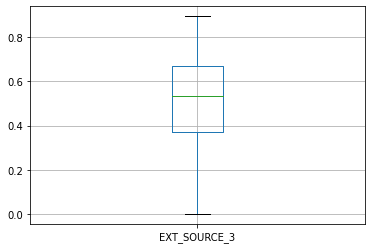

In [10]:
data_devsample.drop(columns = ['DAYS_BIRTH',"TIME"], inplace = True, axis = 1)
data_devsample.boxplot(column=['EXT_SOURCE_3'])

In [11]:
median_value = data_devsample.EXT_SOURCE_3.median()
data_devsample.dropna(subset=['AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_YEAR', 
                              'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_HOUR',
                              'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON'],inplace = True)
data_devsample.fillna(value=median_value, inplace=True)


In [12]:
data_devsample.shape

(69202, 63)

* **Handling the catagorical variables**

In [13]:
catcol = set(data_devsample.columns) - set(num_col)
data_devsample[catcol].head(5)

,FLAG_OWN_CAR,NAME_FAMILY_STATUS,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_TYPE_SUITE,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,CODE_GENDER,NAME_INCOME_TYPE
0,N,Married,Transport: type 2,Y,Secondary / secondary special,Family,Cash loans,House / apartment,SATURDAY,M,Working
1,Y,Married,XNA,Y,Secondary / secondary special,Unaccompanied,Cash loans,With parents,THURSDAY,M,Pensioner
2,N,Married,Business Entity Type 2,Y,Secondary / secondary special,Unaccompanied,Cash loans,House / apartment,WEDNESDAY,F,Working
3,N,Married,Business Entity Type 3,Y,Secondary / secondary special,Unaccompanied,Cash loans,House / apartment,TUESDAY,F,Commercial associate
4,N,Married,Housing,Y,Higher education,Unaccompanied,Revolving loans,House / apartment,WEDNESDAY,F,Working


In [14]:
data_devsample[catcol].describe()

,FLAG_OWN_CAR,NAME_FAMILY_STATUS,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_TYPE_SUITE,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,CODE_GENDER,NAME_INCOME_TYPE
count,69202,69202,69202,69202,69202,69202,69202,69202,69202,69202,69202
unique,2,5,58,2,5,8,2,6,7,3,6
top,N,Married,Business Entity Type 3,Y,Secondary / secondary special,Unaccompanied,Cash loans,House / apartment,WEDNESDAY,F,Working
freq,44966,44833,15287,47698,48863,56071,62667,61631,11944,45660,35570


In [15]:
data_devsample["ORGANIZATION_TYPE"].value_counts()

Business Entity Type 3    15287
XNA                       12382
Self-employed              8246
Other                      3783
Medicine                   2657
Business Entity Type 2     2415
Government                 2365
School                     2060
Trade: type 7              1750
Kindergarten               1623
Construction               1492
Business Entity Type 1     1370
Transport: type 4          1222
Trade: type 3               785
Industry: type 9            774
Security                    730
Industry: type 3            710
Housing                     674
Industry: type 11           617
Military                    614
Bank                        560
Police                      558
Transport: type 2           539
Agriculture                 528
Security Ministries         505
Postal                      465
Restaurant                  389
Trade: type 2               387
Services                    370
Industry: type 7            340
University                  294
Transpor

* **Aberrantly there are some mistakes in data entry the is variable names that should be entered under another name that will help reduce the number of features after the encoding**


**Business Entity Type 1&2&3 >> Business**

**Transport: type 1&2&3&4  >> Industry: type 1**

**Mobile & Telecom >> Industry: type 3**

**Construction >> Industry: type 5**

**Services & Hotel & Cleaning & Restaurant >> Industry: type 6**

**Advertising >> Industry: type 7**

**Agriculture >> Industry: type 8**

**School & Kindergarten & University  >>Industry: type 10**

**Trade: type 1&2&3&4&5&6 & Bank & Insurance & Realtor >> Industry: type 11**

**Medicine & Emergency >> Industry: type 12**

**Religion & Culture &  Security & Electricity & Housing & Postal >> Other**

**Legal Services & Security Ministries & Police & Military >> Government**

In [16]:
NEW_ORGANIZATION_TYPE = {
           "Government":["Legal Services","Security Ministries","Police","Military","Postal"],
           "Other":["Religion","Electricity","Security","Culture","Housing"],
           "Industry: type 12":["Emergency","Medicine"],
           "Industry: type 11":["Realtor","Insurance","Bank","Military","Trade: type 1",
                                "Trade: type 2","Trade: type 3","Trade: type 4","Trade: type 5","Trade: type 6"],
           "Industry: type 10":["School","Kindergarten","University"],
           "Industry: type 8":["Agriculture"],
           "Industry: type 7":["Advertising"],
           "Industry: type 6":["Services","Hotel","Cleaning","Restaurant"],
           "Industry: type 5":["Construction"],
           "Industry: type 3":["Telecom","Mobile"],
           "Industry: type 1":["Transport: type 1","Transport: type 2","Transport: type 3"],
           "Business":["Business Entity Type 1","Business Entity Type 2","Business Entity Type 3"]
          }

In [17]:
for key, values in NEW_ORGANIZATION_TYPE.items():
    data_devsample["ORGANIZATION_TYPE"].replace(dict.fromkeys(values,key),inplace = True) 
data_devsample["ORGANIZATION_TYPE"].value_counts()      
        

Business             19072
XNA                  12382
Self-employed         8246
Other                 5487
Government            4596
Industry: type 10     4004
Industry: type 12     2865
Industry: type 11     2820
Trade: type 7         1750
Industry: type 5      1647
Transport: type 4     1222
Industry: type 1      1069
Industry: type 6      1050
Industry: type 3       927
Industry: type 9       774
Industry: type 8       530
Industry: type 7       441
Industry: type 4       196
Industry: type 2       111
Industry: type 13       13
Name: ORGANIZATION_TYPE, dtype: int64

In [18]:
data_devsample[catcol].describe()

,FLAG_OWN_CAR,NAME_FAMILY_STATUS,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_TYPE_SUITE,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,CODE_GENDER,NAME_INCOME_TYPE
count,69202,69202,69202,69202,69202,69202,69202,69202,69202,69202,69202
unique,2,5,20,2,5,8,2,6,7,3,6
top,N,Married,Business,Y,Secondary / secondary special,Unaccompanied,Cash loans,House / apartment,WEDNESDAY,F,Working
freq,44966,44833,19072,47698,48863,56071,62667,61631,11944,45660,35570


In [19]:
data_devsample["NAME_FAMILY_STATUS"].value_counts()      

Married                 44833
Single / not married     9814
Civil marriage           6424
Separated                4465
Widow                    3666
Name: NAME_FAMILY_STATUS, dtype: int64

In [20]:
data_devsample["NAME_FAMILY_STATUS"].replace("Civil marriage","Married",inplace = True)
data_devsample["NAME_FAMILY_STATUS"].replace("Widow","Single / not married",inplace = True)
data_devsample["NAME_FAMILY_STATUS"].replace("Separated","Single / not married",inplace = True)
data_devsample["NAME_FAMILY_STATUS"].value_counts()      

Married                 51257
Single / not married    17945
Name: NAME_FAMILY_STATUS, dtype: int64

In [21]:
data_devsample["WEEKDAY_APPR_PROCESS_START"].value_counts()      

WEDNESDAY    11944
TUESDAY      11820
THURSDAY     11436
MONDAY       11371
FRIDAY       11238
SATURDAY      7760
SUNDAY        3633
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

In [22]:
data_devsample.drop("WEEKDAY_APPR_PROCESS_START",axis = 1 , inplace = True)

In [23]:
data_devsample["FLAG_OWN_REALTY"].value_counts()      

Y    47698
N    21504
Name: FLAG_OWN_REALTY, dtype: int64

In [24]:
data_devsample["FLAG_OWN_CAR"].value_counts()      

N    44966
Y    24236
Name: FLAG_OWN_CAR, dtype: int64

In [25]:
data_devsample["CODE_GENDER"].value_counts()      

F      45660
M      23540
XNA        2
Name: CODE_GENDER, dtype: int64

In [26]:
data_devsample["NAME_INCOME_TYPE"].value_counts()      

Working                 35570
Commercial associate    16187
Pensioner               12385
State servant            5052
Student                     7
Businessman                 1
Name: NAME_INCOME_TYPE, dtype: int64

In [27]:
data_devsample["ORGANIZATION_TYPE"].value_counts()      

Business             19072
XNA                  12382
Self-employed         8246
Other                 5487
Government            4596
Industry: type 10     4004
Industry: type 12     2865
Industry: type 11     2820
Trade: type 7         1750
Industry: type 5      1647
Transport: type 4     1222
Industry: type 1      1069
Industry: type 6      1050
Industry: type 3       927
Industry: type 9       774
Industry: type 8       530
Industry: type 7       441
Industry: type 4       196
Industry: type 2       111
Industry: type 13       13
Name: ORGANIZATION_TYPE, dtype: int64

In [28]:
data_devsample["NAME_EDUCATION_TYPE"].value_counts()      

Secondary / secondary special    48863
Higher education                 17256
Incomplete higher                 2220
Lower secondary                    818
Academic degree                     45
Name: NAME_EDUCATION_TYPE, dtype: int64

In [29]:
data_devsample["NAME_CONTRACT_TYPE"].value_counts()/len(data_devsample)*100  

Cash loans         90.556631
Revolving loans     9.443369
Name: NAME_CONTRACT_TYPE, dtype: float64

In [30]:
data_devsample["NAME_TYPE_SUITE"].value_counts()/len(data_devsample)*100     

Unaccompanied         81.025115
Family                12.869570
Spouse, partner        3.757117
Children               1.034652
Other_B                0.514436
0.5352762504724826     0.465304
Other_A                0.248548
Group of people        0.085258
Name: NAME_TYPE_SUITE, dtype: float64

In [31]:
data_devsample["NAME_TYPE_SUITE"].replace("Spouse, partner","Accompanied",inplace = True)
data_devsample["NAME_TYPE_SUITE"].replace("Children","Accompanied",inplace = True)
data_devsample["NAME_TYPE_SUITE"].replace("Other_A","Accompanied",inplace = True)
data_devsample["NAME_TYPE_SUITE"].replace("Other_B","Accompanied",inplace = True)
data_devsample["NAME_TYPE_SUITE"].replace("Family","Accompanied",inplace = True)
data_devsample["NAME_TYPE_SUITE"].replace("Group of people","Accompanied",inplace = True)
data_devsample["NAME_TYPE_SUITE"].replace("Spouse, partner","Accompanied",inplace = True)
data_devsample = data_devsample.loc[data_devsample["NAME_TYPE_SUITE"] != 0.5352762504724826]
data_devsample["NAME_TYPE_SUITE"].value_counts() 

Unaccompanied    56071
Accompanied      12809
Name: NAME_TYPE_SUITE, dtype: int64

In [32]:
data_devsample["NAME_HOUSING_TYPE"].value_counts()/len(data_devsample)*100  

House / apartment      89.075203
With parents            4.596400
Municipal apartment     3.616434
Rented apartment        1.521487
Office apartment        0.860918
Co-op apartment         0.329559
Name: NAME_HOUSING_TYPE, dtype: float64

In [33]:
data_devsample.shape

(68880, 62)

In [34]:
catcol = set(data_devsample.columns) - set(num_col)
data_devsample[catcol].describe()

,FLAG_OWN_CAR,NAME_FAMILY_STATUS,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_TYPE_SUITE,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,CODE_GENDER,NAME_INCOME_TYPE
count,68880,68880,68880,68880,68880,68880,68880,68880,68880,68880
unique,2,2,20,2,5,2,2,6,3,6
top,N,Married,Business,Y,Secondary / secondary special,Unaccompanied,Cash loans,House / apartment,F,Working
freq,44753,51039,18982,47587,48675,56071,62396,61355,45458,35418


In [35]:
y = data_devsample['TARGET']
x = data_devsample.drop(["TARGET"], axis = 1) 
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.20, random_state=0)
print("ytrain" ,ytrain.shape ,"\n", "xtest",xtest.shape)

ytrain (55104,) 
 xtest (13776, 61)


In [36]:
x_enc = pd.get_dummies(x, columns = set(catcol))
xtest_enc =pd.get_dummies(xtest, columns = set(catcol))
xtrain_enc =pd.get_dummies(xtrain, columns = set(catcol))

In [37]:
def std_sclr(df):
    scaler = StandardScaler()
    return( pd.DataFrame(data= scaler.fit_transform(df),columns = df.columns ))
    

In [38]:
xtrain_scaled  = std_sclr(xtrain_enc)
xtest_scaled  = std_sclr(xtest_enc)
x_scaled  = std_sclr(x_enc)

**Modeling**

In [39]:
SVC_par = {"kernel" : ["rbf" , "poly"],
           "C" : [1,2,3]
            }
forest_par = {"n_estimators" : [100,200,300],
                  "max_depth" : [20,35,50],
                  "min_samples_split" : [5,10,15],
                  "max_features" : ["sqrt"]
                 }
logreg_par = {
    'C' : [0.1,0.2,0.5]
}

In [40]:
forest = RandomForestClassifier()
log_reg = LogisticRegression()
svc = SVC()

In [41]:
forest_grid = GridSearchCV(forest,forest_par,
             cv = 5,return_train_score = True)
SVR_grid =  GridSearchCV(svc,SVC_par,
             cv = 5 ,return_train_score = True)
log_grid = GridSearchCV(log_reg,logreg_par,
             cv = 5 ,return_train_score = True)

In [42]:
regressors = [forest_grid,SVR_grid,log_grid]
mean_rmse = {}
for reg in regressors:
    reg.fit(xtrain_scaled,ytrain)
    scores = cross_val_score(reg.best_estimator_,xtrain_scaled,ytrain,cv = 5, scoring = 'f1')
    mean_rmse[str(reg)] = scores


In [43]:
s = str(regressors[0])
mean_rmse[s] = mean_rmse[s].mean()

In [44]:
s = str(regressors[1])
mean_rmse[s] = mean_rmse[s].mean()

In [45]:
s = str(regressors[2])
mean_rmse[s] = mean_rmse[s].mean()

In [109]:
for i in regressors:
    print('f1-score for '+str(i.estimator)+' is '+str(mean_rmse[str(i)]))

f1-score for RandomForestClassifier(max_depth=35, max_features='sqrt', min_samples_split=10,
                       n_estimators=200) is 0.0004700352526439482
f1-score for SVC(C=2) is 0.0
f1-score for LogisticRegression(C=0.2) is 0.010245652778788587


In [128]:
ypred = forest_grid.best_estimator_.predict(xtest_scaled)
mean_squared_error(ytest, ypred)

0.07730836236933798

In [129]:
ypred = SVR_grid.best_estimator_.predict(xtest_scaled)
mean_squared_error(ytest, ypred)

0.07738095238095238

In [130]:
ypred = log_grid.best_estimator_.predict(xtest_scaled)
mean_squared_error(ytest, ypred)

0.07781649245063879

In [118]:
#xtest_scaled['NAME_INCOME_TYPE_Businessman'] = xtrain_scaled['CODE_GENDER_XNA']

In [119]:
#xtest_scaled['NAME_INCOME_TYPE_Businessman'].rename('CODE_GENDER_XNA')

0       -0.006025
1       -0.006025
2       -0.006025
3       -0.006025
4       -0.006025
           ...   
13771   -0.006025
13772   -0.006025
13773   -0.006025
13774   -0.006025
13775   -0.006025
Name: CODE_GENDER_XNA, Length: 13776, dtype: float64

In [124]:
#xtest_scaled.rename(columns={"NAME_INCOME_TYPE_Businessman": "CODE_GENDER_XNA"}, inplace  = True)